In [3]:
import numpy as np
import pandas as pd
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import cross_val_score
from sklearn.feature_extraction.text import HashingVectorizer, CountVectorizer
from sklearn import manifold, decomposition, linear_model, ensemble, neighbors, cross_validation
%matplotlib inline
import seaborn as sns
import sklearn
import matplotlib.pyplot as plt
import xgboost
import re
import nltk
import pymorphy2
import enchant

from heamy.dataset import Dataset
from heamy.estimator import Regressor, Classifier
from heamy.pipeline import ModelsPipeline


### будем использовать в качестве метрики RMSE

In [4]:
def rmse(x,y):
    return np.mean((x - y) ** 2) ** 0.5

### загрузка данных url_domain_train. Пока работаем только с ними

In [5]:
urls_train_df = pd.read_csv('data/url_domain_train.csv', header=None, delimiter='\t')

In [6]:
urls_train_df.columns = ['id', 'url', 'count']
urls_train_df.head()

,id,url,count
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1
1,000000014B60815F65B38258011B6C01,rutracker.org,4
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1


### нужно учесть count

#### попробуем разбивать url'ы на части: login.rutracker.org $\to$ 'login rutracker org'

In [7]:
sep_tmp = urls_train_df
sep_tmp['url'] = sep_tmp['url'].astype('str')
sep_tmp['space'] = ' '
sep_tmp['array_of_url'] = (sep_tmp['url'] + sep_tmp['space']).apply(lambda x: re.findall(r"[\w']+",x)) * sep_tmp['count']
sep_tmp.drop(['space'], axis = 1, inplace=True)
sep_tmp.head()

,id,url,count,array_of_url
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1,"[login, rutracker, org]"
1,000000014B60815F65B38258011B6C01,rutracker.org,4,"[rutracker, org, rutracker, org, rutracker, or..."
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1,"[admin, tour, spb, net]"
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1,"[czinfo, ru]"
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1,"[forumsostav, ru]"


In [8]:
sep_URLS = pd.DataFrame(sep_tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))
sep_URLS.head()

,array_of_url
id,
000000013CB5719C0000A2C90002C101,"[[id, rambler, ru], [mail, rambler, ru], [r0, ..."
00000001442BE24000001B7D00F50801,"[[1prime, ru], [autorambler, ru], [chellak, ru..."
00000001448580F800003F1B31FB0901,"[[bosch, korolev, ru]]"
0000000145BDB2FF000157971645E901,"[[aptekanizkihcen, ua], [colady, ru], [gorod, ..."
000000014602771F0000DB9359714C01,"[[astrorok, ru], [diets, ru], [edaplus, info],..."


#### без разбиения самих url'ов

In [9]:
tmp = urls_train_df
tmp['url'] = tmp['url'].astype('str')
tmp['space'] = ' '
tmp['array_of_url'] = (tmp['url'] + tmp['space']).apply(lambda x: x.split(' ')[:-1]) * tmp['count']
tmp.drop(['space'], axis = 1, inplace=True)
tmp.head()

,id,url,count,array_of_url
0,000000014B60815F65B38258011B6C01,login.rutracker.org,1,[login.rutracker.org]
1,000000014B60815F65B38258011B6C01,rutracker.org,4,"[rutracker.org, rutracker.org, rutracker.org, ..."
2,000000014C03DA2A47AC433A0C755201,admin.tour-spb.net,1,[admin.tour-spb.net]
3,000000014C03DA2A47AC433A0C755201,czinfo.ru,1,[czinfo.ru]
4,000000014C03DA2A47AC433A0C755201,forumsostav.ru,1,[forumsostav.ru]


In [10]:
URLS = pd.DataFrame(tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))

In [11]:
sep_URLS.head()

,array_of_url
id,
000000013CB5719C0000A2C90002C101,"[[id, rambler, ru], [mail, rambler, ru], [r0, ..."
00000001442BE24000001B7D00F50801,"[[1prime, ru], [autorambler, ru], [chellak, ru..."
00000001448580F800003F1B31FB0901,"[[bosch, korolev, ru]]"
0000000145BDB2FF000157971645E901,"[[aptekanizkihcen, ua], [colady, ru], [gorod, ..."
000000014602771F0000DB9359714C01,"[[astrorok, ru], [diets, ru], [edaplus, info],..."


In [12]:
URLS.head()

,array_of_url
id,
000000013CB5719C0000A2C90002C101,"[[id.rambler.ru], [mail.rambler.ru], [r0.ru]]"
00000001442BE24000001B7D00F50801,"[[1prime.ru], [autorambler.ru], [chellak.ru], ..."
00000001448580F800003F1B31FB0901,[[bosch-korolev.ru]]
0000000145BDB2FF000157971645E901,"[[aptekanizkihcen.ua], [colady.ru], [gorod.dp...."
000000014602771F0000DB9359714C01,"[[astrorok.ru], [diets.ru], [edaplus.info], [e..."


In [13]:
def sep_f(x):
    a = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            a.append(x[i][j])
    return " ".join(a)

In [14]:
def f(x):
    a = []
    for i in range(len(x)):
        for j in range(len(x[i])):
            a.append(x[i][j])
    return a

In [15]:
URLS['list'] = URLS.array_of_url.apply(f)
URLS.drop(['array_of_url'], axis = 1, inplace=True)

In [16]:
sep_URLS['list'] = sep_URLS.array_of_url.apply(sep_f)
sep_URLS.drop(['array_of_url'], axis = 1, inplace=True)

In [17]:
URLS['id'] = URLS.index
URLS.index = range(len(URLS))
URLS.columns = ['urls', 'id']

In [18]:
sep_URLS['id'] = sep_URLS.index
sep_URLS.index = range(len(sep_URLS))
sep_URLS.columns = ['urls', 'id']

In [19]:
age_train_df = pd.read_csv('data/age_profile_train.csv', header=None, delimiter='\t')
age_train_df.columns = ['id', 'age']
age_train_df.head()

,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48


In [25]:
print age_train_df.shape
print age_train_df.age.nunique()

(118679, 2)
99


In [32]:
print sorted(age_train_df.age.unique())

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 96, 97, 98, 99]


(array([  2.90000000e+01,   3.16000000e+02,   3.43000000e+02,
          3.96000000e+02,   2.52000000e+02,   3.60000000e+01,
          1.72000000e+02,   1.56000000e+02,   2.06000000e+02,
          1.92000000e+02,   2.05000000e+02,   1.68000000e+02,
          1.80000000e+02,   2.25000000e+02,   4.36000000e+02,
          7.90000000e+01,   4.26000000e+02,   7.03000000e+02,
          8.97000000e+02,   1.22000000e+03,   1.85600000e+03,
          2.18300000e+03,   2.34400000e+03,   2.77000000e+03,
          3.23700000e+03,   6.09000000e+02,   3.56200000e+03,
          4.72000000e+03,   5.08200000e+03,   5.13200000e+03,
          4.96900000e+03,   4.86300000e+03,   4.73400000e+03,
          4.46500000e+03,   4.18900000e+03,   7.27000000e+02,
          3.28600000e+03,   4.03900000e+03,   3.77600000e+03,
          3.60900000e+03,   3.60500000e+03,   3.27300000e+03,
          3.15700000e+03,   3.06400000e+03,   2.78100000e+03,
          4.73000000e+02,   1.94800000e+03,   2.04800000e+03,
        

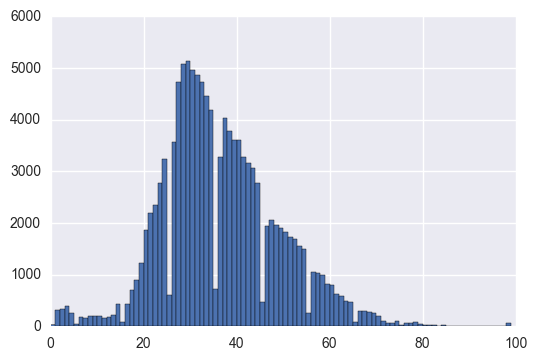

In [28]:
plt.hist(age_train_df.age, bins=99)

In [53]:
age_train_df.groupby('age')['id'].count()[20:30]

age
20    1856
21    2183
22    2344
23    2770
24    3237
25     609
26    3562
27    4720
28    5082
29    5132
Name: id, dtype: int64

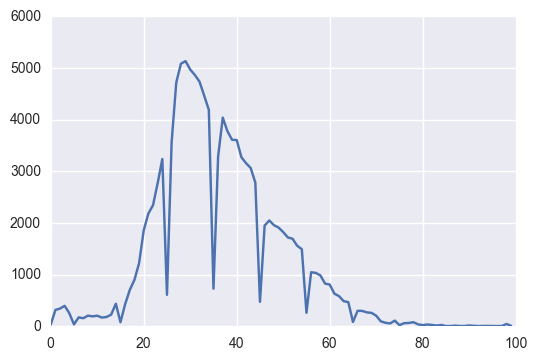

In [40]:
plt.plot(age_train_df.groupby('age')['id'].count())

In [47]:
train_df = URLS.merge(age_train_df, on='id', how='left')

In [48]:
sep_train_df = sep_URLS.merge(age_train_df, on = 'id', how='left')

In [49]:
train_df.head()

,urls,id,age
0,"[id.rambler.ru, mail.rambler.ru, r0.ru]",000000013CB5719C0000A2C90002C101,53
1,"[1prime.ru, autorambler.ru, chellak.ru, docs.c...",00000001442BE24000001B7D00F50801,48
2,[bosch-korolev.ru],00000001448580F800003F1B31FB0901,28
3,"[aptekanizkihcen.ua, colady.ru, gorod.dp.ua, i...",0000000145BDB2FF000157971645E901,44
4,"[astrorok.ru, diets.ru, edaplus.info, eshzdoro...",000000014602771F0000DB9359714C01,48


In [50]:
sep_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r0 ru,000000013CB5719C0000A2C90002C101,53
1,1prime ru autorambler ru chellak ru docs cntd ...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua colady ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diets ru edaplus info eshzdorovo r...,000000014602771F0000DB9359714C01,48


In [87]:
strange_df_url = train_df[train_df['age'] == 25]
strange_df_url.shape

(609, 3)

In [88]:
strange_df_url.head()

,urls,id,age
612,"[1tv.ru, 4shopping.ru, belushka-info.ru, belus...",000000014FEA049674082B4609851C01,25
700,"[compromat.ru, echo.msk.ru, echo.msk.ru, echo....",0000000150446B88188950720A032701,25
955,"[guzei.com, mail-pda.rambler.ru, mail-pda.ramb...",0000000151078F9C950E788C0ECFFD01,25
995,"[50.joblib.ru, 911-job.ru, 9955599.ru, 9955599...",00000001511E227479896FF20761BB01,25
1114,"[agbs007.ru, aimfar.solution.weborama.fr, andr...",00000001516A753BBF536DE208BE5701,25


In [89]:
print strange_df_url.urls[612]

['1tv.ru', '4shopping.ru', 'belushka-info.ru', 'belushka.ru', 'caticat.ru', 'fishki.net', 'fontanka.ru', 'gamebuka.ru', 'gazeta.spb.ru', 'hairlife.ru', 'jlady.ru', 'kinohost.nov.ru', 'ladykiss.ru', 'mau.ru', 'orator.ee', 'ostrov-mira.ru', 'psiholog.mirtesen.ru', 'toramp.com', 'woman.ru', 'woman.ru', 'woman.ru', 'worldmagik.ru', 'zavolosami.ru', 'zoodusha.ru']


In [90]:
print strange_df_url.urls[700]

['compromat.ru', 'echo.msk.ru', 'echo.msk.ru', 'echo.msk.ru', 'echo.msk.ru', 'echo.msk.ru', 'echo.msk.ru', 'estet-portal.com', 'id.rambler.ru', 'it-like.ru', 'kino-teatr.ru', 'kino-teatr.ru', 'm.kp.ru', 'm.kp.ru', 'm.kp.ru', 'm.rambler.ru', 'mail-pda.rambler.ru', 'menquestions.ru', 'narcotics.su', 'netnarkotik.ru', 'news.rambler.ru', 'news.sportbox.ru', 'pulson.ru', 'sobesednik.ru', 'xn--j1aidcn.org']


In [93]:
set(set(strange_df_url.urls[612]) & set( strange_df_url.urls[700]))

set()

In [ ]:
string_before_stemming = sep_train_df.urls[1]

### стемминг слов

In [17]:
stemmer = nltk.stem.PorterStemmer()

In [18]:
def stemming(x):
    ret_array = []
    array = x.split(" ")
    for word in array:
        ret_array.append(stemmer.stem(word))
    return " ".join(ret_array)

In [19]:
stemming(sep_train_df.urls[1])

u'1prime ru autorambl ru chellak ru doc cntd ru doc cntd ru echo msk ru echo msk ru expert ru expert ru expert ru expert ru expert ru expert ru expert ru financ rambler ru financ rambler ru forb ru forb ru forum ixbt com garant ru govoritmoskva ru kommers ru kp ru lenta ru mait ru metronew ru mk ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news rambler ru news smi2 ru norm load ru pfr kirov ru pfrf ru photographi on the ru realti rambler ru ren tv ren tv ren tv ren tv ren tv riafan ru rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rn onlin rossbanki ru secretmag ru tehnorma ru tiu ru top68 ru tvc ru tvzvezda ru vesti ru video rambler ru video rambler ru weekend rambler

In [21]:
stem_train_df = sep_train_df.copy()

In [22]:
stem_train_df.urls = stem_train_df.urls.apply(lambda x: stemming(x))

In [23]:
sep_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r0 ru,000000013CB5719C0000A2C90002C101,53
1,1prime ru autorambler ru chellak ru docs cntd ...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua colady ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diets ru edaplus info eshzdorovo r...,000000014602771F0000DB9359714C01,48


In [24]:
stem_train_df.head()

,urls,id,age
0,id rambler ru mail rambler ru r0 ru,000000013CB5719C0000A2C90002C101,53
1,1prime ru autorambl ru chellak ru doc cntd ru ...,00000001442BE24000001B7D00F50801,48
2,bosch korolev ru,00000001448580F800003F1B31FB0901,28
3,aptekanizkihcen ua coladi ru gorod dp ua i ovk...,0000000145BDB2FF000157971645E901,44
4,astrorok ru diet ru edaplu info eshzdorovo ru ...,000000014602771F0000DB9359714C01,48


#### попробуем через уменьшение размерностей

In [ ]:
sep_train_df.head()

In [ ]:
sep_X = sep_train_df.urls

In [ ]:
hw = HashingVectorizer(n_features=2000, non_negative=True).fit(sep_X)
sep_X = hw.transform(sep_X).todense()

In [ ]:
transformer = sklearn.decomposition.NMF(n_components=400)
X_nmf = transformer.fit_transform(sep_X)

### начнём делать кросс-валидацию и обработку признаков

In [25]:
y_urls = sep_train_df.age.values

In [ ]:
train_df.urls = train_df.urls.apply(lambda x: " ".join(x))

In [ ]:
train_df.urls[:2]

In [ ]:
sep_train_df.urls[:2]

In [ ]:
stem_train_df.urls[:2]

In [26]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
sep_X = tfidf.fit_transform(sep_train_df.urls.values)

In [ ]:
score = []
for k in range(5):
    mean = []
    for i in range(5):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_nmf, y_urls,\
                                                                                  test_size = 0.3)
        xgb_reg = xgboost.XGBRegressor(n_estimators=500, learning_rate=0.03)
        xgb_reg.fit(train_data, y_train)
        print "usual = ", rmse(xgb_reg.predict(test_data), y_test)
        mean.append(rmse(xgb_reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
print np.mean(score)

In [27]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()

In [28]:
stem_X = tfidf.fit_transform(stem_train_df.urls.values)

In [29]:
stem_X

<118603x99057 sparse matrix of type '<type 'numpy.float64'>'
	with 2835687 stored elements in Compressed Sparse Row format>

In [50]:
svd = decomposition.TruncatedSVD(n_components=500)
svd_X = svd.fit_transform(stem_X)

In [68]:
svd_X.shape

(118603, 500)

In [85]:
score = []
pen = [0.1, 0.5, 1, 1.5, 2, 2.5]
for c in pen:
    mean = []
    for i in range(5):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(svd_X, y_urls,\
                                                                                  test_size = 0.3)
        reg = linear_model.LinearRegression()
        reg.fit(train_data, y_train)
        print "usual = ", rmse(reg.predict(test_data), y_test)
        mean.append(rmse(reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
print np.mean(score)

usual =  11.7692080252
usual =  11.6959843795
usual =  11.6865694007
usual =  11.6728403956
usual =  11.7089822438
usual =  11.6654801187


KeyboardInterrupt: 

In [56]:
reg = linear_model.LinearRegression()
reg.fit(train_data, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

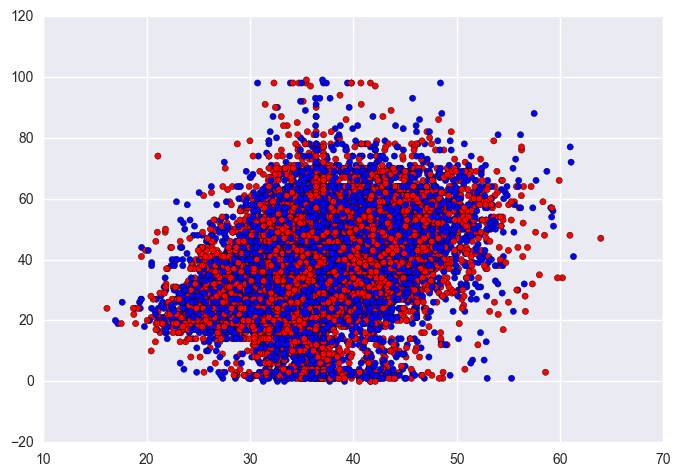

In [66]:
plt.scatter(reg.predict(test_data), y_test, c=['r','b'])
plt.figure(figsize=(12,12))


In [ ]:
plt.hist(stem_X.mean(axis=1), bins=10, range=(0.0000,0.0002))
plt.figure(figsize=(12,10))

In [ ]:
print sep_X.shape
#print X.shape
print stem_X.shape

In [ ]:
stem_score = []
for k in range(5):
    stem_mean = []
    for i in range(5):

        train_data, test_data, y_train, y_test = cross_validation.train_test_split(stem_X, y_urls,\
                                                                                    test_size = 0.3)
        
        lin_reg = linear_model.SGDRegressor(n_iter=450, alpha=0.000008)
        lin_reg.fit(train_data, y_train)
        print 'with stem urls ',rmse(lin_reg.predict(test_data), y_test)
        stem_mean.append(rmse(lin_reg.predict(test_data), y_test))
        
    stem_score.append(np.mean(stem_mean))

print 'in general with stem = and feature cut', np.mean(stem_score)
    

In [ ]:
score = []
sep_score = []
stem_score = []
for k in range(5):
    mean = []
    sep_mean = []
    stem_mean = []
    for i in range(5):

    
        #train_data, test_data, y_train, y_test = cross_validation.train_test_split(X_nmf, y, \
        #                                                             test_size = 0.3)
    
        #xgb_rg = xgboost.XGBRegressor(n_estimators=n, learning_rate=0.03)
        #xgb_rg.fit(train_data, y_train)
        #print 'xgboost_rmse = ', rmse(xgb_rg.predict(test_data), y_test)
        #mean.append(rmse(xgb_rg.predict(test_data), y_test))
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(X, y,\
                                                                                  test_size = 0.3)
        lin_reg = linear_model.SGDRegressor(n_iter=350, alpha=0.000008)
        lin_reg.fit(train_data, y_train)
        print "usual = ",rmse(lin_reg.predict(test_data), y_test)
        mean.append(rmse(lin_reg.predict(test_data), y_test))
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(sep_X, y,\
                                                                                    test_size = 0.3)
        
        lin_reg = linear_model.SGDRegressor(n_iter=350, alpha=0.000008)
        lin_reg.fit(train_data, y_train)
        print 'with sep urls ',rmse(lin_reg.predict(test_data), y_test)
        sep_mean.append(rmse(lin_reg.predict(test_data), y_test))
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(stem_X, y,\
                                                                                    test_size = 0.3)
        
        lin_reg = linear_model.SGDRegressor(n_iter=450, alpha=0.000008)
        lin_reg.fit(train_data, y_train)
        print 'with stem urls ',rmse(lin_reg.predict(test_data), y_test)
        stem_mean.append(rmse(lin_reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
    sep_score.append(np.mean(sep_mean))
    stem_score.append(np.mean(stem_mean))
print np.mean(score)
print 'in general with sep =', np.mean(sep_score)
print 'in general with stem =', np.mean(stem_score)
    

### svd

In [ ]:
from sklearn import pipeline, preprocessing, feature_extraction

In [ ]:
# обычный датасет
dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :])
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

print rmse(y[itest], results)

### Теперь загрузим title_unify_train

In [70]:
title_train = pd.read_csv('data/title_unify_train.csv', header=None, sep='\t')
title_train.head()

,0,1,2
0,000000014B6D41C13D777E8314725401,коляна лента прикол,1
1,0000000150707ACB8A82451C0307BC01,candi410 rambler ru входящая рамблер-почта,1
2,0000000150707ACB8A82451C0307BC01,cosmopolitan витамин волос для женщина журнал ...,1
3,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин страница тов...,1
4,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин товар экипир...,2


In [71]:
title_train.columns = ['id', 'unify', 'count']

In [72]:
tmp = title_train
tmp['unify'] = tmp['unify'].astype('str')
tmp['space'] = ' '
tmp['array_of_unify'] = (tmp['unify'] + tmp['space']).apply(lambda x: x.split(' ')[:-1]) * tmp['count']
tmp.drop(['space'], axis = 1, inplace=True)
tmp.head()

,id,unify,count,array_of_unify
0,000000014B6D41C13D777E8314725401,коляна лента прикол,1,"[коляна, лента, прикол]"
1,0000000150707ACB8A82451C0307BC01,candi410 rambler ru входящая рамблер-почта,1,"[candi410, rambler, ru, входящая, рамблер-почта]"
2,0000000150707ACB8A82451C0307BC01,cosmopolitan витамин волос для женщина журнал ...,1,"[cosmopolitan, витамин, волос, для, женщина, ж..."
3,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин страница тов...,1,"[realbox, бокс, для, интернет-магазин, страниц..."
4,0000000150707ACB8A82451C0307BC01,realbox бокс для интернет-магазин товар экипир...,2,"[realbox, бокс, для, интернет-магазин, товар, ..."


In [73]:
UNIFY = pd.DataFrame(tmp.groupby('id').array_of_unify.apply(lambda x: x.tolist()))

In [74]:
UNIFY['list'] = UNIFY.array_of_unify.apply(f)
UNIFY.drop(['array_of_unify'], axis = 1, inplace=True)

In [75]:
UNIFY['id'] = UNIFY.index
UNIFY.index = range(len(UNIFY))
UNIFY.columns = ['unify', 'id']
UNIFY.head()

,unify,id
0,"[бесплатный, надёжный, почта, рамблер, электро...",000000013CB5719C0000A2C90002C101
1,"[24-х, 34-х, до, договор, неделя, новость, пре...",00000001442BE24000001B7D00F50801
2,"[авто, бош, контакт, королёв, сервис, авто, бо...",00000001448580F800003F1B31FB0901
3,"[ua, втрать, війни, донбасі, за, на, новини, о...",0000000145BDB2FF000157971645E901
4,"[black, walnut, грецкий, орех, чёрный, inmomen...",000000014602771F0000DB9359714C01


In [76]:
train_un = UNIFY.merge(age_train_df, on='id', how='left')
train_un.head()

,unify,id,age
0,"[бесплатный, надёжный, почта, рамблер, электро...",000000013CB5719C0000A2C90002C101,53
1,"[24-х, 34-х, до, договор, неделя, новость, пре...",00000001442BE24000001B7D00F50801,48
2,"[авто, бош, контакт, королёв, сервис, авто, бо...",00000001448580F800003F1B31FB0901,28
3,"[ua, втрать, війни, донбасі, за, на, новини, о...",0000000145BDB2FF000157971645E901,44
4,"[black, walnut, грецкий, орех, чёрный, inmomen...",000000014602771F0000DB9359714C01,48


In [77]:
strange_df = train_un[train_un['age'] == 25]
strange_df.shape

(581, 3)

In [78]:
strange_df.head()

,unify,id,age
595,"[freeplai, sim, игра, персонаж, пообщаться, фо...",000000014FEA049674082B4609851C01,25
682,"[chrome, googl, ip, адрес, блог, видео, как, л...",0000000150446B88188950720A032701,25
930,"[радиостанция, список, тверь]",0000000151078F9C950E788C0ECFFD01,25
968,"[account, hotel, hr, manag, вакансия, москва, ...",00000001511E227479896FF20761BB01,25
1084,"[1200х90х2200, душевая, кабина, купить, низ, п...",00000001516A753BBF536DE208BE5701,25


In [139]:
age_train_df.sort(columns='age', inplace=True)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


In [140]:
age_train_df

,id,age
71634,00000BBC57050D8475C9214E00166201,0
56920,00000BBC56F03FB7C2704C97012F4301,0
109036,06204BBF559E4EA5000004E74C2C1301,0
74545,05F6593C5300C7A000000AD2FF691401,0
58137,00000BBC56F1B94E5FB893B6002B6901,0
37824,0000004656F9484618756995474C5201,0
66269,00000BBC56FD0A228E0CD934000B4801,0
95745,060D95B656E995430000055FE7753B01,0
28443,0000004656D5D2E8B45C6D1901A00401,0
102221,0619EEBB5668C8FA00006DBE64CC8701,0


In [163]:
tmp = pd.DataFrame(age_train_df.groupby('age')['id'].unique())

In [164]:
tmp.head(10)

,id
age,
0,"[00000BBC57050D8475C9214E00166201, 00000BBC56F..."
1,"[060E405455506BF300006DBEE722F801, 0618BD1E56D..."
2,"[0000002B56EBC0C66E80DAF3020A4A01, 0619EEBB55C..."
3,"[0000004656ED29ED1921519A13EB8501, 00000046568..."
4,"[000000465690A2F1854A57814B27F701, 00000046568..."
5,"[061F87EB562E3A8A000004F88F73EB01, 0000002B56F..."
6,"[060C443D56EAE66D0000055B0BF74801, 00000BBC56C..."
7,"[0000004656FCD02706F713580DB33001, 00000BBC56F..."
8,"[0000004656F24A5F66E072617616DA01, 0000004656F..."


id    [00000BBC57050D8475C9214E00166201, 00000BBC56F...
Name: 0, dtype: object


In [116]:
age_train_df.sort('id').head(20)

/Users/Roman/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,id,age
0,000000013CB5719C0000A2C90002C101,53
1,00000001442BE24000001B7D00F50801,48
2,00000001448580F800003F1B31FB0901,28
3,0000000145BDB2FF000157971645E901,44
4,000000014602771F0000DB9359714C01,48
5,0000000147B2D6F311DB5C4201B7FB01,36
6,0000000147C68954150168D701A8B801,33
7,0000000147EB76D738CD80750C879701,41
8,00000001482AAFB69FA5228008AC2A01,51
9,0000000148390BB56A6B22BB178D3901,32


In [133]:
tmp_tf_idf = sklearn.feature_extraction.text.TfidfVectorizer(analyzer='char', ngram_range=(1,1))

In [134]:
tmp_train = tmp_tf_idf.fit_transform(age_train_df.id)

In [135]:
tmp_train

<118679x16 sparse matrix of type '<type 'numpy.float64'>'
	with 1522124 stored elements in Compressed Sparse Row format>

In [136]:
tmp_y = age_train_df.age

In [137]:
score = []
pen = [0.1, 0.5, 1, 1.5, 2, 2.5]
for c in pen:
    mean = []
    for i in range(5):
        
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(tmp_train, tmp_y,\
                                                                                  test_size = 0.3)
        reg = linear_model.LinearRegression()
        reg.fit(train_data, y_train)
        print "usual = ", rmse(reg.predict(test_data), y_test)
        mean.append(rmse(reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
print np.mean(score)

usual =  12.5487450106
usual =  12.5085637871
usual =  12.5128697948
usual =  12.5675552169
usual =  12.5183392696
usual =  12.6403100354
usual =  12.6352074634
usual =  12.5176174486
usual =  12.6093910888
usual =  12.56640308
usual =  12.5832931338
usual =  12.595512783
usual =  12.561822015
usual =  12.4876430796
usual =  12.5170179208
usual =  12.5568752551
usual =  12.5102274658
usual =  12.6020955016
usual =  12.5928050802
usual =  12.5601069464
usual =  12.5504781315
usual =  12.5895191595
usual =  12.5801673099
usual =  12.634806791
usual =  12.5702971868
usual =  12.4954507487


KeyboardInterrupt: 

In [ ]:
morph = pymorphy2.MorphAnalyzer()

In [ ]:
print type(u'прив')

In [ ]:
p = morph.parse(u'привет')[0]
p.normal_form

In [ ]:
p = morph.parse(u'привет -ды ls -a')[0]
print p.normal_form
print type(p.normal_form)

In [ ]:
def norm_form(x):
    tmp = " ".join(x)
    string = unicode(tmp,'utf-8','ignore')
    p = morph.parse(string)[0]
    return p.normal_form

In [ ]:
train_morph = train_un.copy()

In [ ]:
train_morph.unify = train_morph.unify.apply(lambda x: norm_form(x))

In [ ]:
train_morph.head()

In [ ]:
tfidf = sklearn.feature_extraction.text.TfidfVectorizer()
morph_X = tfidf.fit_transform(train_morph.unify.values)

In [ ]:
morph_y = train_morph.age

In [ ]:
score = []

for k in range(5):
    mean = []
    for i in range(5):
        train_data, test_data, y_train, y_test = cross_validation.train_test_split(morph_X, y,\
                                                                                    test_size = 0.3)
        
        lin_reg = linear_model.SGDRegressor(n_iter=550, alpha=0.00003)
        lin_reg.fit(train_data, y_train)
        print rmse(lin_reg.predict(test_data), y_test)
        mean.append(rmse(lin_reg.predict(test_data), y_test))
        
    score.append(np.mean(mean))
print np.mean(score)

In [ ]:
# обычный датасет
dataset1 = Dataset(X[itrain, :], y[itrain], X[itest, :])
# NMF
dataset2 = Dataset(X_nmf[itrain, :], y[itrain], X_nmf[itest, :])

# линейная модель на обычных данных
lr = Regressor(dataset=dataset1, 
                     estimator=linear_model.LinearRegression,
                     parameters={'normalize': True},
                     name='lr')

# линейная модель на TFIDF от обычных данных
def tfidf_lr_(X_train, y_train, X_test, y_test=None, random_state=8888):
    model = pipeline.Pipeline([('tfidf', feature_extraction.text.TfidfTransformer()), 
                                ('linear_model', linear_model.LinearRegression())])
    model.fit(X_train, y_train)
    return model.predict(X_test)

tfidf_lr = Regressor(dataset=dataset1,
                     estimator=tfidf_lr_,
                     name='tfidf_lr')

# ExtraTrees на NMF
rf = Regressor(dataset=dataset2, 
                     estimator=ensemble.ExtraTreesRegressor,
                     parameters={'n_estimators': 100, 'n_jobs': -1},
                     name='rf')

# Stack two models
# Returns new dataset with out-of-fold predictions
meta_pipeline = ModelsPipeline(lr, tfidf_lr, rf)
stack_ds = meta_pipeline.blend(proportion=0.2,seed=111)

# Train LinearRegression on stacked data (second stage)
stacker = Regressor(dataset=stack_ds, estimator=LinearRegression)
results = stacker.predict()

print rmse(y[itest], results)

### данные для отправки

In [70]:
urls_test_df = pd.read_csv('data/url_domain_test.csv', header=None, delimiter='\t')
urls_test_df.columns = ['id', 'url', 'count']
urls_test_df.id.nunique()

19974

In [71]:
urls_test_df.head()

,id,url,count
0,0000000151004FF4ADD746DA10685A01,afisha.ru,2
1,0000000151004FF4ADD746DA10685A01,aif.ru,1
2,0000000151004FF4ADD746DA10685A01,aimfar.solution.weborama.fr,1
3,0000000151004FF4ADD746DA10685A01,alkotest.ru,1
4,0000000151004FF4ADD746DA10685A01,aptekamos.ru,1


In [72]:
sep_tmp = urls_test_df
sep_tmp['url'] = sep_tmp['url'].astype('str')
sep_tmp['space'] = ' '
sep_tmp['array_of_url'] = (sep_tmp['url'] + sep_tmp['space']).apply(lambda x: re.findall(r"[\w']+",x)) * sep_tmp['count']
sep_tmp.drop(['space'], axis = 1, inplace=True)
sep_tmp.head()

,id,url,count,array_of_url
0,0000000151004FF4ADD746DA10685A01,afisha.ru,2,"[afisha, ru, afisha, ru]"
1,0000000151004FF4ADD746DA10685A01,aif.ru,1,"[aif, ru]"
2,0000000151004FF4ADD746DA10685A01,aimfar.solution.weborama.fr,1,"[aimfar, solution, weborama, fr]"
3,0000000151004FF4ADD746DA10685A01,alkotest.ru,1,"[alkotest, ru]"
4,0000000151004FF4ADD746DA10685A01,aptekamos.ru,1,"[aptekamos, ru]"


In [73]:
TEST_URLS = pd.DataFrame(sep_tmp.groupby('id').array_of_url.apply(lambda x: x.tolist()))

In [74]:
TEST_URLS['list'] = TEST_URLS.array_of_url.apply(sep_f)
TEST_URLS.drop(['array_of_url'], axis = 1, inplace=True)

In [75]:
TEST_URLS['id'] = TEST_URLS.index
TEST_URLS.index = range(len(TEST_URLS))
TEST_URLS.columns = ['urls', 'id']
TEST_URLS.head()

,urls,id
0,1000bankov ru 1tv ru 1tv ru 1tv ru 1tv ru 1tv ...,000000014A02348E701552980349FF01
1,autorambler ru bilettorg ru dsol druzhba ru fa...,000000014A10EA183BF8594A0B2AB201
2,photosight ru photosight ru photosight ru phot...,000000014A4FE5C33A929D4C26943601
3,base consultant ru dogovor obrazets ru fd ru m...,000000014B7BB9957784A9BC0AC9F401
4,assessor ru assessor ru audit it ru base garan...,000000014C7749F896D82C2B01E8B801


In [77]:
TEST_URLS.urls = TEST_URLS.urls.apply(lambda x: stemming(x))

In [86]:
X_test_urls = tfidf.transform(TEST_URLS.urls.values)

In [87]:
svd_X_test = svd.transform(X_test_urls)

In [88]:
reg.fit(svd_X, y_urls)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [ ]:
X_test_urls.shape

In [ ]:
sep_X.shape

In [ ]:
lin_reg = linear_model.SGDRegressor(n_iter=750, alpha=0.000006)
lin_reg.fit(sep_X, y_urls)

In [89]:
urls_pred = reg.predict(svd_X_test)

### теперь прогноз по title

In [ ]:
titles_test_df = pd.read_csv('data/title_unify_test.csv', header=None, delimiter='\t')
titles_test_df.columns = ['id', 'unify', 'count']
titles_test_df.id.nunique()

In [ ]:
tmp = titles_test_df
tmp['unify'] = tmp['unify'].astype('str')
tmp['space'] = ' '
tmp['array_of_unify'] = (tmp['unify'] + tmp['space']).apply(lambda x: x.split(' ')[:-1]) * tmp['count']
tmp.drop(['space'], axis = 1, inplace=True)
tmp.head()

In [ ]:
UNIFY_TEST = pd.DataFrame(tmp.groupby('id').array_of_unify.apply(lambda x: x.tolist()))

In [ ]:
UNIFY_TEST['list'] = UNIFY_TEST.array_of_unify.apply(f)
UNIFY_TEST.drop(['array_of_unify'], axis = 1, inplace=True)

In [ ]:
UNIFY_TEST['id'] = UNIFY_TEST.index
UNIFY_TEST.index = range(len(UNIFY_TEST))
UNIFY_TEST.columns = ['unify', 'id']
UNIFY_TEST.head()

In [ ]:
UNIFY_TEST.unify = UNIFY_TEST.unify.apply(lambda x: norm_form(x))

In [ ]:
X_test_titles = tfidf.transform(UNIFY_TEST.unify.values)

In [ ]:
lin_reg = linear_model.SGDRegressor(n_iter=750, alpha=0.000006)
lin_reg.fit(morph_X, morph_y)

In [ ]:
titles_pred = lin_reg.predict(X_test_titles)

In [ ]:
print urls_pred.shape
print titles_pred.shape

In [90]:
TEST_URLS['age'] = urls_pred

In [91]:
TEST_URLS = TEST_URLS[['id', 'age']]
TEST_URLS.columns = ['Id', 'age']

In [92]:
mean_array = TEST_URLS.age.mean()

In [93]:
mean_array

37.91684272650016

In [94]:
TEST_URLS.head()

,Id,age
0,000000014A02348E701552980349FF01,40.710335
1,000000014A10EA183BF8594A0B2AB201,42.191024
2,000000014A4FE5C33A929D4C26943601,35.440998
3,000000014B7BB9957784A9BC0AC9F401,33.997869
4,000000014C7749F896D82C2B01E8B801,40.603813


In [95]:
mean_array*np.ones(10)

array([ 37.91684273,  37.91684273,  37.91684273,  37.91684273,
        37.91684273,  37.91684273,  37.91684273,  37.91684273,
        37.91684273,  37.91684273])

In [96]:
random_sol = pd.read_csv('data/sample_submission.csv')
random_sol.head()

,Id,age
0,000000014A02348E701552980349FF01,36.04347
1,000000014A10EA183BF8594A0B2AB201,36.04347
2,000000014A4FE5C33A929D4C26943601,36.04347
3,000000014B7BB9957784A9BC0AC9F401,36.04347
4,000000014C7749F896D82C2B01E8B801,36.04347


In [97]:
miss_idx = set(random_sol.Id.values) - set(TEST_URLS.Id.values)
miss_df = pd.DataFrame(zip(list(miss_idx), mean_array*np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [98]:
TEST_URLS = TEST_URLS.append(miss_df, ignore_index=True)

In [ ]:
urls_pred

In [ ]:
titles_pred

In [ ]:
mean_array = UNIFY_TEST.age.mean()

In [ ]:
UNIFY_TEST['age'] = titles_pred

In [ ]:
UNIFY_TEST = UNIFY_TEST[['id', 'age']]
UNIFY_TEST.columns = ['Id', 'age']

In [ ]:
miss_idx = set(random_sol.Id.values) - set(UNIFY_TEST.Id.values)
miss_df = pd.DataFrame(zip(list(miss_idx), mean_array*np.ones(len(miss_idx))))
miss_df.columns = ['Id', 'age']

In [ ]:
UNIFY_TEST = UNIFY_TEST.append(miss_df, ignore_index=True)

In [ ]:
print UNIFY_TEST.shape
print TEST_URLS.shape

In [100]:
TEST = TEST_URLS.copy()

In [101]:
TEST['age'] = TEST_URLS['age']

In [ ]:
TEST.head()

In [102]:
TEST.to_csv('my_solution.csv', index=False)

In [103]:
TEST.shape

(19979, 2)

In [ ]:
print urls_test_df.shape
print TEST_URLS.shape

In [ ]:
print urls_test_df.id.nunique()
print TEST_URLS.id.nunique()